# Prompt generation

This is a temporary notebook in which we will generate the prompt for clip given the set of classes from Flowers102.

Specifically, we first generate the prompt from scratch using a LLDM for each class, then we will refine a specific set of prompts given the classes and the previously generated prompts. This latter step will be employed in case CLIP will predict different class with similar probability in order to create a more detailed prompt.

In [104]:
import torch
import numpy as np
import torch.nn.functional as F
import torchvision
from tqdm import tqdm

In [105]:
device = "cuda" if torch.cuda.is_available() else "cpu"
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"


**Loading the classes from Flowers102**

In [106]:
def get_data(data_dir="./data", transform=None):
    """Load Flowers102 train, validation and test sets.
    Args:
        data_dir (str): Directory where the dataset will be stored.
        transform (torch.Compose)
    Returns:
        tuple: A tuple containing the train, validation, and test sets.
    """
    train = torchvision.datasets.Flowers102(root=data_dir, split="train", download=True, transform=transform)
    val = torchvision.datasets.Flowers102(root=data_dir, split="val", download=True, transform=transform)
    test = torchvision.datasets.Flowers102(root=data_dir, split="test", download=True, transform=transform)
    return train, val, test

In [107]:
def base_novel_categories(dataset):
    # set returns the unique set of all dataset classes
    all_classes = set(dataset._labels)
    # and let's count them
    num_classes = len(all_classes)

    # here list(range(num_classes)) returns a list from 0 to num_classes - 1
    # then we slice the list in half and generate base and novel category lists
    base_classes = list(range(num_classes))[:num_classes//2]
    novel_classes = list(range(num_classes))[num_classes//2:]
    return base_classes, novel_classes

In [108]:
_, _, tmp_test = get_data()
base_classes, novel_classes = base_novel_categories(tmp_test)
CLASS_NAMES = ["pink primrose", "hard-leaved pocket orchid", "canterbury bells", "sweet pea", "english marigold", "tiger lily", "moon orchid", "bird of paradise", "monkshood", "globe thistle", "snapdragon", "colt's foot", "king protea", "spear thistle", "yellow iris", "globe-flower", "purple coneflower", "peruvian lily", "balloon flower", "giant white arum lily", "fire lily", "pincushion flower", "fritillary", "red ginger", "grape hyacinth", "corn poppy", "prince of wales feathers", "stemless gentian", "artichoke", "sweet william", "carnation", "garden phlox", "love in the mist", "mexican aster", "alpine sea holly", "ruby-lipped cattleya", "cape flower", "great masterwort", "siam tulip", "lenten rose", "barbeton daisy", "daffodil", "sword lily", "poinsettia", "bolero deep blue", "wallflower", "marigold", "buttercup", "oxeye daisy", "common dandelion", "petunia", "wild pansy", "primula", "sunflower", "pelargonium", "bishop of llandaff", "gaura", "geranium", "orange dahlia", "pink-yellow dahlia?", "cautleya spicata", "japanese anemone", "black-eyed susan", "silverbush", "californian poppy", "osteospermum", "spring crocus", "bearded iris", "windflower", "tree poppy", "gazania", "azalea", "water lily", "rose", "thorn apple", "morning glory", "passion flower", "lotus", "toad lily", "anthurium", "frangipani", "clematis", "hibiscus", "columbine", "desert-rose", "tree mallow", "magnolia", "cyclamen", "watercress", "canna lily", "hippeastrum", "bee balm", "ball moss", "foxglove", "bougainvillea", "camellia", "mallow", "mexican petunia", "bromelia", "blanket flower", "trumpet creeper", "blackberry lily"]
print("Base Class Names:", [(i, CLASS_NAMES[i]) for i in base_classes])
print("Novel Class Names:", [(i, CLASS_NAMES[i]) for i in novel_classes])

Base Class Names: [(0, 'pink primrose'), (1, 'hard-leaved pocket orchid'), (2, 'canterbury bells'), (3, 'sweet pea'), (4, 'english marigold'), (5, 'tiger lily'), (6, 'moon orchid'), (7, 'bird of paradise'), (8, 'monkshood'), (9, 'globe thistle'), (10, 'snapdragon'), (11, "colt's foot"), (12, 'king protea'), (13, 'spear thistle'), (14, 'yellow iris'), (15, 'globe-flower'), (16, 'purple coneflower'), (17, 'peruvian lily'), (18, 'balloon flower'), (19, 'giant white arum lily'), (20, 'fire lily'), (21, 'pincushion flower'), (22, 'fritillary'), (23, 'red ginger'), (24, 'grape hyacinth'), (25, 'corn poppy'), (26, 'prince of wales feathers'), (27, 'stemless gentian'), (28, 'artichoke'), (29, 'sweet william'), (30, 'carnation'), (31, 'garden phlox'), (32, 'love in the mist'), (33, 'mexican aster'), (34, 'alpine sea holly'), (35, 'ruby-lipped cattleya'), (36, 'cape flower'), (37, 'great masterwort'), (38, 'siam tulip'), (39, 'lenten rose'), (40, 'barbeton daisy'), (41, 'daffodil'), (42, 'sword 

I will simply use the variable `CLASS_NAMES` as list of classes.

```python

## Preparing data and CLIP

In [109]:
import clip

device = "cuda" if torch.cuda.is_available() else "cpu"
# available models = ['RN50', 'RN101', 'RN50x4', 'RN50x16', 'RN50x64', 'ViT-B/32', 'ViT-B/16', 'ViT-L/14', 'ViT-L/14@336px']
clip_model, preprocess = clip.load("ViT-B/16", device=device)

# preprocess contains CLIP's pre-defined augmentations, let's inspect them!
preprocess

#Lets select just sample from classes of the generated prompts
train_set, val_set, test_set = get_data(transform=preprocess)

# Loadig LLM (LLaMA 3.1 8B)

In [110]:
# Install Ollama if not already installed
# !curl -fsSL https://ollama.com/install.sh | sh
# !pip install ollama


## Prompt generation

### 1) Single prompt per class - Llama 3.2 3B custom

The follwoing function generates a prompt for each class and return a dictionary with the class as key and the prompt as value.

it uses a custom model, if you want just to use a system prompt add a message before the "user" message.

In [111]:
from ollama import chat
from ollama import ChatResponse

def generate_prompts(classes=[], model="llama3.2-clip-prompts"):
    """
    Generate prompts for a list of classes using a custom LLaMa model.
    Args:
        model: The LLaDA model to use for generating prompts.
        classes: A list of class names for which to generate prompts.
    Returns:
        A dictionary where keys are class names and values are generated prompts.
    """
    
    # Unifying all the classes into a single string, that will be the input prompt together with the system prompt
    class_string = ", ".join(classes)
    
    response: ChatResponse = chat(model=model, messages=[
        {
            'role': 'user',
            'content': class_string,
        },
    ])
    
    captions = response.message.content
    
    # Prompts are separated by semicolons, so we split them to create a list
    extracted_prompts = captions.split(';')
    extracted_prompts = [prompt.strip() for prompt in extracted_prompts if prompt.strip()]
    
    # Building dictionary (class name -> prompt)
    class_prompt_dict = dict(zip(classes, extracted_prompts))
    
    return class_prompt_dict

### 2) Prompt variants - LLama 3.1 11B
This other function generates prompt variants for a single class, it uses a bigger model.
The prompt embeddings should be averaged before being used in CLIP.

In [179]:
SYSTEM_PROMPT = """You are a vision-language expert.

Input format  
• The user will give **one** Oxford-102 flower class name (e.g. “Daffodil”).  

Output format  
• Return **exactly 10** short, visually grounded prompts.  
• Separate the prompts with **“; ”** (semicolon + space).  
• Do **not** add a semicolon after the final prompt.  
• Output nothing else.

Content rules for each prompt  
1. Start with a different prefix chosen from this set (use each at most once):  
   “A photo of a”, “An image of a”, “A close-up of a”, “A macro shot of a”,  
   “A studio photo of a”, “An outdoor photo of a”, “A botanical plate of a”,  
   “A well-lit photograph of a”, “A side view of a”, “A top-down view of a”.  
2. Immediately include the **number of flowers** in the frame (e.g. “single”, “one”, “pair of”, “three”).  
3. Name the flower class exactly as given.  
4. Mention dominant colour(s) plus 1-2 key visual cues (petal count/shape, centre, leaves, stem).  
5. Keep each prompt ≤ 25 words.  
6. Use only information visible in a typical image; avoid subjective or non-visual terms (beautiful, symbolic, fragrant, etc.).  
7. End each prompt **without** a period.

Return the ten prompts in one line, separated by “; ”, and nothing else.
"""

In [173]:
def generate_prompt_variants_single_class(class_name, model="llama3.1:8b"):
    """
    Generate a single prompt for a given class using a custom LLaMa model.
    Args:
        class_name: The class name for which to generate a prompt.
        model: The LLaDA model to use for generating the prompt.
    Returns:
        A string containing the generated prompt.
    """
    
    response: ChatResponse = chat(model=model, messages=[
        {
            'role': 'system',
            'content': SYSTEM_PROMPT,
        },
        {
            'role': 'user',
            'content': class_name,
        },
    ])
    
    extracted_prompts = response.message.content.split(';')
    extracted_prompts = [prompt.strip() for prompt in extracted_prompts if prompt.strip()]
    return extracted_prompts

### 🧪 Mini test

In [114]:
test_prompts = generate_prompt_variants_single_class(CLASS_NAMES[0], model="llama3.1:8b")
test_prompts

['A photo of single pink primrose with yellow centre and five-petaled rosette',
 'An image of three pink primroses with delicate white stripes on petals and slender stems',
 'A close-up of pair of pink primroses showcasing their fragrant, star-shaped flowers',
 'A macro shot of one pink primrose displaying its vibrant, pink hue and intricate patterns',
 'An outdoor photo of a cluster of pink primroses with green foliage and wispy tendrils',
 'A studio photo of single pink primrose against white background and soft focus',
 'A well-lit photograph of multiple pink primroses arranged in loose bouquet and sprigs',
 'A side view of three pink primroses showcasing their delicate, bell-shaped flowers',
 'An image of single pink primrose with prominent stamens and green sepals',
 'A top-down view of a patch of pink primroses growing amidst lush grass and daisies']

### 3) Llama 3.2 11B vision

In [115]:
import ollama


def generate_prompt_vision_model(class_name, image_path: str, model="llama3.2-vision:11b"):
    """
    sample: A sample from the dataset, which contains an image and a label.
    model: The model to use for generating prompts.  
    """

    
    response = ollama.chat(
        model=model,
        messages=[
        {
            'role': 'user',
            'content': f"Write a PROMPT FOR CLIP MODEL of an image of a {class_name} flower. Answer with just the prompt, no other text.",
            'images': [image_path],
        }]
    )
    
    return response.message.content

Let's take a sample image to test the vision model.

In [116]:
from random import randint

classe = 6  # per esempio

random_idx = randint(0, len(train_set) - 1)
sample = train_set[random_idx]
sample_image = sample[0]
sample_label = sample[1]
sample_path = train_set._image_files[random_idx]


Show image

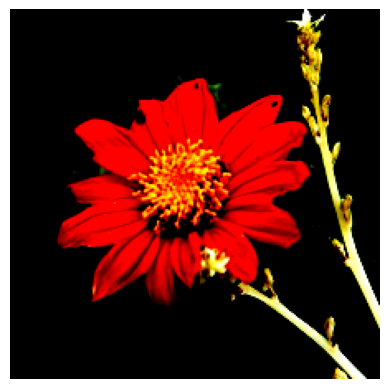

In [117]:
import matplotlib.pyplot as plt
import torch

# If image is normalized (e.g. using ImageNet mean/std), reverse it
def unnormalize(img_tensor, mean, std):
    mean = torch.tensor(mean).reshape(3, 1, 1)
    std = torch.tensor(std).reshape(3, 1, 1)
    return img_tensor * std + mean

# Unnormalize if needed, otherwise skip this step
# sample_image = unnormalize(sample_image, mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])

# Convert to [H, W, C] and clip to [0, 1]
img_np = sample_image.permute(1, 2, 0).numpy().clip(0, 1)

# Show image
plt.imshow(img_np)
plt.axis('off')
plt.show()

Convert the image and send it to the model.

In [118]:
from os import path

class_name = CLASS_NAMES[sample_label]

prompts = generate_prompt_vision_model(class_name, sample_path)

print("Generated Prompt:", prompts)

Generated Prompt: **Crop out the background and the flower's stem, focusing on the orange dahlia flower's petals and center.**


# Testing class generation

In [141]:
import torch
print(torch.version.cuda)
print(torch.cuda.is_available())
print(device)


12.6
True
cuda


In [152]:
MAX_NUM_CLASSES = 70

### Testing with CLIP (method 1 -> single prompt per class)

In [153]:
# ! Generate prompts for all classes
flower_prompts_dict = generate_prompts(CLASS_NAMES[:MAX_NUM_CLASSES]) # it should take 1 minute or less
flower_prompts_dict

{'pink primrose': 'Here are the captions for each flower class in a single line, separated by semicolons:\n\nA close-up photo of a Pink Primrose, a delicate pink flower with cup-shaped petals and a slender stem',
 'hard-leaved pocket orchid': 'A photograph of a Hard-leaved Pocket Orchid, a small white flower with tightly closed petals and a distinctive leafy habit',
 'canterbury bells': 'An image of a Canterbury Bell, a tall, bell-shaped flower in shades of blue and white',
 'sweet pea': 'A photo of a Sweet Pea, a fragrant, pastel-colored flower with delicate, ruffled petals',
 'english marigold': 'An image of an English Marigold, a bright yellow flower with daisy-like petals and a strong, pungent scent',
 'tiger lily': 'A photograph of a Tiger Lily, a large, orange flower with recurved petals and a prominent center',
 'moon orchid': 'A close-up of a Moon Orchid, a white or pale-colored flower with long, thin petals and a distinctive lip',
 'bird of paradise': 'An image of a Bird of Pa

if i generated less classes than the number of classes in the dataset, I will use the generated prompts to create a dictionary with the class as key and the prompt as value.

In [154]:
my_category_samples = []
for sample_id, class_name in enumerate(train_set._labels):
    if CLASS_NAMES[class_name] in flower_prompts_dict.keys():
        my_category_samples.append(sample_id)
        
my_train_set = torch.utils.data.Subset(train_set, my_category_samples)

In [155]:
# !conda install --yes -c pytorch pytorch=2.7.1 torchvision cudatoolkit=12.8
# !pip install ftfy regex tqdm
# !pip install git+https://github.com/openai/CLIP.git

### CLIP "vanilla" eval

In [156]:
@torch.no_grad() # we don't want gradients
def eval(clip_model, dataset, categories, batch_size, device, label=""):
    # let's set the model in evaluation mode
    clip_model.eval()

    # Remap labels into a contiguous set starting from zero
    contig_cat2idx = {cat: idx for idx, cat in enumerate(categories)}
    
    # here we apply the standard CLIP template used for oxford flowers to all categories
    # and immediately tokenize each sentence (convert natural language into numbers - feel free to print the text input to inspect them)
    text_inputs = clip.tokenize(
        [f"a photo of a {CLASS_NAMES[c]}, a type of flower." for c in categories]
    ).to(device)

    # we can encode the text features once as they are shared for all images
    # therefore we do it outside the evaluation loop
    text_features = clip_model.encode_text(text_inputs)
    # and here we normalize them (standard pratice with CLIP)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # simple dataloader creation
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # here we store the number of correct predictions we will make
    correct_predictions = 0
    for image, target in tqdm(dataloader, desc=label):
        # base categories range from 0 to 50, whil novel ones from 51 to 101
        # therefore we must map categories to the [0, 50], otherwise we will have wrong predictions
        # Map targets in contiguous set starting from zero
        # Labels needs to be .long() in pytorch
        target = torch.Tensor([contig_cat2idx[t.item()] for t in target]).long()

        image = image.to(device)
        target = target.to(device)

        # forward image through CLIP image encoder
        image_features = clip_model.encode_image(image)
        # and normalize
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # here cosine similarity between image and text features and keep the argmax for every row (every image)
        predicted_class = (image_features @ text_features.T).argmax(dim=-1)
        # now we check which are correct, and sum them (False == 0, True == 1)
        correct_predictions += (predicted_class == target).sum().item() 
        
        # for i in range(len(predicted_class != target)):
        #     if not predicted_class[i] == target[i]:
        #         print(f"Image {i} predicted as {CLASS_NAMES[predicted_class[i]]}, but it is {CLASS_NAMES[target[i]]}")

    # and now we compute the accuracy
    accuracy = correct_predictions / len(dataset)
    return accuracy

accuracy = eval(clip_model=clip_model, dataset=my_train_set, categories=[i for i in range(len(CLASS_NAMES))], batch_size=128, device=device, label="🧠 Zero-shot evaluation on Base Classes")

print()
print(f"🔍 Base classes accuracy: {accuracy*100:.2f}%")

🧠 Zero-shot evaluation on Base Classes:   0%|          | 0/6 [00:00<?, ?it/s]

🧠 Zero-shot evaluation on Base Classes: 100%|██████████| 6/6 [00:03<00:00,  1.78it/s]


🔍 Base classes accuracy: 65.51%


### Our method (first approach)

In [157]:
@torch.no_grad() # we don't want gradients
def eval(clip_model, dataset, prompt_dict, batch_size, device, label=""):
    # let's set the model in evaluation mode
    clip_model.eval()

    # Remap labels into a contiguous set starting from zero
    contig_cat2idx = {idx: idx for idx, cat in enumerate(prompt_dict.keys())}
    
    # here we apply the standard CLIP template used for oxford flowers to all categories
    # and immediately tokenize each sentence (convert natural language into numbers - feel free to print the text input to inspect them)
    text_inputs = clip.tokenize(
        [prompt for prompt in prompt_dict.values()]
    ).to(device)

    # we can encode the text features once as they are shared for all images
    # therefore we do it outside the evaluation loop
    text_features = clip_model.encode_text(text_inputs)
    # and here we normalize them (standard pratice with CLIP)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # simple dataloader creation
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # here we store the number of correct predictions we will make
    correct_predictions = 0
    for image, target in tqdm(dataloader, desc=label):
        # base categories range from 0 to 50, whil novel ones from 51 to 101
        # therefore we must map categories to the [0, 50], otherwise we will have wrong predictions
        # Map targets in contiguous set starting from zero
        # Labels needs to be .long() in pytorch
        target = torch.Tensor([contig_cat2idx[t.item()] for t in target]).long()

        image = image.to(device)
        target = target.to(device)

        # forward image through CLIP image encoder
        image_features = clip_model.encode_image(image)
        # and normalize
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # here cosine similarity between image and text features and keep the argmax for every row (every image)
        predicted_class = (image_features @ text_features.T).argmax(dim=-1)
        # now we check which are correct, and sum them (False == 0, True == 1)
        correct_predictions += (predicted_class == target).sum().item()
        
        # if (predicted_class != target).any():
        #     # if there are any wrong predictions, print them
        #     for i in range(len(predicted_class)):
        #         if predicted_class[i] != target[i]:
        #             print(f"Image: {i}, Wrong prediction: {CLASS_NAMES[predicted_class[i]]} (predicted) vs {CLASS_NAMES[target[i]]} (target)")

    # and now we compute the accuracy
    accuracy = correct_predictions / len(dataset)
    return accuracy

accuracy = eval(clip_model=clip_model, dataset=my_train_set, prompt_dict=flower_prompts_dict, batch_size=128, device=device, label="🧠 Zero-shot evaluation on Base Classes")

print()
print(f"🔍 Base classes accuracy: {accuracy*100:.2f}%")

🧠 Zero-shot evaluation on Base Classes:   0%|          | 0/6 [00:00<?, ?it/s]

🧠 Zero-shot evaluation on Base Classes: 100%|██████████| 6/6 [00:03<00:00,  1.81it/s]


🔍 Base classes accuracy: 11.88%


## Second approach (variants)

In [174]:
flower_dict_var = {}
for label in CLASS_NAMES[:MAX_NUM_CLASSES]:
    prompts = generate_prompt_variants_single_class(label, model="llama3.1:8b")
    
    flower_dict_var[label] = prompts

print(flower_dict_var["pink primrose"])

['A close-up of one pink Primrose with delicate white petals and a prominent yellow centre', 'An image of a single pink Primrose with three-petaled flowers and a slender green stem', 'A macro shot of two pink Primroses with five-lobed leaves and a bright yellow centre', 'An outdoor photo of a pair of pink Primroses in full bloom, surrounded by pale green foliage', 'A studio photo of one pink Primrose with soft white petals and delicate yellow stamens', 'An image of three pink Primroses on a single stem, each flower having 5 petals', 'A well-lit photograph of a group of five pink Primroses with prominent yellow centres and slender green leaves', 'A side view of two pink Primroses growing together, surrounded by long, thin stems', 'A top-down view of one pink Primrose, showing its white base and delicate green sepals.']


In [175]:
# prepare dataset with used classes for this experiment
my_category_samples = []
for sample_id, class_name in enumerate(train_set._labels):
    if CLASS_NAMES[class_name] in flower_dict_var.keys():
        my_category_samples.append(sample_id)
        
my_train_set2 = torch.utils.data.Subset(train_set, my_category_samples)

### 🧪 Eval (approach 2)

In [176]:
flower_dict_var

{'pink primrose': ['A close-up of one pink Primrose with delicate white petals and a prominent yellow centre',
  'An image of a single pink Primrose with three-petaled flowers and a slender green stem',
  'A macro shot of two pink Primroses with five-lobed leaves and a bright yellow centre',
  'An outdoor photo of a pair of pink Primroses in full bloom, surrounded by pale green foliage',
  'A studio photo of one pink Primrose with soft white petals and delicate yellow stamens',
  'An image of three pink Primroses on a single stem, each flower having 5 petals',
  'A well-lit photograph of a group of five pink Primroses with prominent yellow centres and slender green leaves',
  'A side view of two pink Primroses growing together, surrounded by long, thin stems',
  'A top-down view of one pink Primrose, showing its white base and delicate green sepals.'],
 'hard-leaved pocket orchid': ['A photo of a single hard-leaved pocket orchid with green leaves and white petals',
  'An image of a pai

In [181]:
@torch.no_grad() # we don't want gradients
def eval(clip_model, dataset, prompt_dict, batch_size, device, label=""):
    
    # let's set the model in evaluation mode
    clip_model.eval()
    
    # get features (average embedding for each class)
    class_features = []

    # Ordine fisso → ci servirà per mappare i target
    ordered_keys = list(prompt_dict.keys())

    for k in ordered_keys:
        prompts = prompt_dict[k]                     # lista di stringhe
        
        embeddings = []
        for prompt in prompts:
            tokens = clip.tokenize(prompt, truncate=True).to(device)  # [N_prompts, 77]

            # Encode & normalize i prompt
            emb = clip_model.encode_text(tokens)        # [N_prompts, 512]
            emb = emb / emb.norm(dim=-1, keepdim=True)
            embeddings.append(emb.squeeze(0))  # [512]

        # Media + rinormalizzazione
        cls_emb = torch.stack(embeddings).mean(dim=0)                   # [512]
        cls_emb = cls_emb / cls_emb.norm()

        class_features.append(cls_emb)

    # Stack → [num_classi, 512]
    text_features = torch.stack(class_features)
    

    # Remap labels into a contiguous set starting from zero
    contig_cat2idx = {idx: idx for idx, cat in enumerate(ordered_keys)}
    

    # simple dataloader creation
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=2)

    # here we store the number of correct predictions we will make
    correct_predictions = 0
    for image, target in tqdm(dataloader, desc=label):
        # base categories range from 0 to 50, whil novel ones from 51 to 101
        # therefore we must map categories to the [0, 50], otherwise we will have wrong predictions
        # Map targets in contiguous set starting from zero
        # Labels needs to be .long() in pytorch
        target = torch.Tensor([contig_cat2idx[t.item()] for t in target]).long()

        image = image.to(device)
        target = target.to(device)

        # forward image through CLIP image encoder
        image_features = clip_model.encode_image(image)
        # and normalize
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # here cosine similarity between image and text features and keep the argmax for every row (every image)
        predicted_class = (image_features @ text_features.T).argmax(dim=-1)
        # now we check which are correct, and sum them (False == 0, True == 1)
        correct_predictions += (predicted_class == target).sum().item()
        

    # and now we compute the accuracy
    accuracy = correct_predictions / len(dataset)
    return accuracy

accuracy = eval(clip_model=clip_model, dataset=my_train_set2, prompt_dict=flower_dict_var, batch_size=128, device=device, label="🧠 Zero-shot evaluation on Base Classes")

print()
print(f"🔍 Base classes accuracy: {accuracy*100:.2f}%")

🧠 Zero-shot evaluation on Base Classes: 100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


🔍 Base classes accuracy: 60.14%


### Save prompt in JSON

In [ ]:
# # Print the generated prompts in the required format
## print("Generated Prompts:")
# print("========================================")
# for k, v in flower_prompts_dict.items():
#     print(f'"{k}": "{v}"')

# import json
# # Save the generated prompts to a JSON file
# with open('generated_prompts.json', 'w') as f:
#     json.dump(flower_prompts_dict, f, indent=4)

Generated Prompts:
"pink primrose": "Here are the captions for each flower class:

A close-up photo of a Pink Primrose, a delicate, cup-shaped flower with pale pink petals and a prominent center"
"hard-leaved pocket orchid": "A photograph of a Hard-leaved Pocket Orchid, an epiphytic orchid with long, thin leaves and small white flowers"
"canterbury bells": "An image of a Canterbury Bell, a bell-shaped flower with bright blue petals and a distinctive shape"
"sweet pea": "A photo of a Sweet Pea, a fragrant, pastel-colored flower with delicate, ruffled petals"
"english marigold": "A photograph of an English Marigold, a bright yellow flower with daisy-like petals and a strong, pungent scent"
"tiger lily": "A close-up of a Tiger Lily, a large, showy flower with bright orange petals and long green stems"
"moon orchid": "An image of a Moon Orchid, a white or pale-colored flower with delicate, curved petals"
"bird of paradise": "A photograph of a Bird of Paradise, a striking, exotic flower wit

## LLDM model (LLaDa 8B - Instruct) and tokenizer

In [ ]:
from transformers import AutoTokenizer, AutoModel

model = AutoModel.from_pretrained('GSAI-ML/LLaDA-8B-Instruct', 
                                  trust_remote_code=True, 
                                  torch_dtype=torch.bfloat16, 
                                  load_in_4bit=True, # use 4-bit quantization to reduce memory usage
                                  device_map="auto" # automatically map model to available devices
                                  ).eval()
tokenizer = AutoTokenizer.from_pretrained('GSAI-ML/LLaDA-8B-Instruct', trust_remote_code=True)


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.
The model weights are not tied. Please use the `tie_weights` method before using the `infer_auto_device` function.
Loading checkpoint shards: 100%|██████████| 6/6 [00:03<00:00,  1.89it/s]


❗ The function for generating the prompt are based on the official LLaDa's repository (you can check it [here](https://github.com/ML-GSAI/LLaDA/blob/main/generate.py))

In [ ]:
def add_gumbel_noise(logits, temperature):
    '''
    The Gumbel max is a method for sampling categorical distributions.
    According to arXiv:2409.02908, for MDM, low-precision Gumbel Max improves perplexity score but reduces generation quality.
    Thus, we use float64.
    '''
    if temperature == 0:
        return logits
    logits = logits.to(torch.float64)
    noise = torch.rand_like(logits, dtype=torch.float64)
    gumbel_noise = (- torch.log(noise)) ** temperature
    return logits.exp() / gumbel_noise


def get_num_transfer_tokens(mask_index, steps):
    '''
    In the reverse process, the interval [0, 1] is uniformly discretized into steps intervals.
    Furthermore, because LLaDA employs a linear noise schedule (as defined in Eq. (8)),
    the expected number of tokens transitioned at each step should be consistent.

    This function is designed to precompute the number of tokens that need to be transitioned at each step.
    '''
    mask_num = mask_index.sum(dim=1, keepdim=True)

    base = mask_num // steps
    remainder = mask_num % steps

    num_transfer_tokens = torch.zeros(mask_num.size(0), steps, device=mask_index.device, dtype=torch.int64) + base

    for i in range(mask_num.size(0)):
        num_transfer_tokens[i, :remainder[i]] += 1

    return num_transfer_tokens


### Prompt generation via diffusion model

The idea is to generate a prompt from a set of tokens set to [MASK], these tokens will iteratively replaced with the most probable tokens given the context of the prompt, the others are kept [MASK]. The process is repeated until the prompt is fully generated.

In [ ]:
@ torch.no_grad()
def generate(model, prompt, steps=128, gen_length=128, block_length=128, temperature=0.,
             cfg_scale=0., remasking='low_confidence', mask_id=126336):
    '''
    Args:
        model: Mask predictor.
        prompt: A tensor of shape (1, L). Defining what the model is required to generate.
        steps: Sampling steps, less than or equal to gen_length.
        gen_length: Generated answer length.
        block_length: Block length, less than or equal to gen_length. If less than gen_length, it means using semi_autoregressive remasking.
        temperature: Categorical distribution sampling temperature.
        cfg_scale: Unsupervised classifier-free guidance scale.
        remasking: Remasking strategy. 'low_confidence' or 'random'.
        mask_id: The toke id of [MASK] is 126336.
    '''
    x = torch.full((1, prompt.shape[1] + gen_length), mask_id, dtype=torch.long).to(model.device)  #! creates a vector with all [MASK] tokens (e.g. [MASK] [MASK] [MASK] ... [MASK])
    x[:, :prompt.shape[1]] = prompt.clone()

    prompt_index = (x != mask_id)

    assert gen_length % block_length == 0
    num_blocks = gen_length // block_length

    assert steps % num_blocks == 0
    steps = steps // num_blocks

    for num_block in range(num_blocks):  #* for each block to be generated we apply a loop of "steps" to make the denoising pass (for internal)
        block_mask_index = (x[:, prompt.shape[1] + num_block * block_length: prompt.shape[1] + (num_block + 1) * block_length:] == mask_id)
        num_transfer_tokens = get_num_transfer_tokens(block_mask_index, steps)  #! calculate the number of tokens to be transferred for each step
        for i in range(steps): #* qui fa gli steps di denoising pass per il blocco corrente
            mask_index = (x == mask_id)
            if cfg_scale > 0.:
                un_x = x.clone()
                un_x[prompt_index] = mask_id
                x_ = torch.cat([x, un_x], dim=0)
                logits = model(x_).logits               #! Model prediction for the current block
                logits, un_logits = torch.chunk(logits, 2, dim=0)
                logits = un_logits + (cfg_scale + 1) * (logits - un_logits)
            else:
                logits = model(x).logits

            logits_with_noise = add_gumbel_noise(logits, temperature=temperature) # add gumbel noise to logits
            x0 = torch.argmax(logits_with_noise, dim=-1) # b, l    -> #! keep only the most likely tokens


            #! the idea here is to reveal some tokens and the others will remain [MASK]
            if remasking == 'low_confidence':
                p = F.softmax(logits, dim=-1)
                x0_p = torch.squeeze(
                    torch.gather(p, dim=-1, index=torch.unsqueeze(x0, -1)), -1) # b, l  -> #* x0_p contains the probability of the token predettto x0 in each position
            elif remasking == 'random':
                x0_p = torch.rand((x0.shape[0], x0.shape[1]), device=x0.device)
            else:
                raise NotImplementedError(remasking)

            x0_p[:, prompt.shape[1] + (num_block + 1) * block_length:] = -np.inf

            x0 = torch.where(mask_index, x0, x)
            confidence = torch.where(mask_index, x0_p, -np.inf)

            transfer_index = torch.zeros_like(x0, dtype=torch.bool, device=x0.device)
            for j in range(confidence.shape[0]):
                _, select_index = torch.topk(confidence[j], k=num_transfer_tokens[j, i])   #! Select the highest probability tokens
                transfer_index[j, select_index] = True       #! reveals the token
            x[transfer_index] = x0[transfer_index]   #! the tokens selected with topk are unlocked and revealed, all others remain [MASK] for the next step

    return x

### Prompt generation given a set of classes
We pass the set of classes and we generate a prompt for each one uisng ther LLDM.

In [ ]:
SYSTEM_PROMPT = """
You are a vision-language expert. Given a list of flower classes, generate natural, detailed captions that describes what the flower looks like, including its color, petal shape, size, and any distinctive features. Each caption should be written as a single sentence that could be used as a prompt for CLIP.

Use the following examples as a guide:

Class: Calendula
→ "A close-up photo of a Calendula, a bright yellow-orange flower with daisy-like petals and sticky stems;"

Class: Rose
→ "A photo of a Rose, a layered flower with soft, velvety petals, often deep red and spiraled in shape;"

Class: Dandelion
→ "An image of a Dandelion, a small yellow flower with thin, radiating petals and a fluffy seed head;"

Class: Tulip
→ "A photograph of a Tulip, a smooth, cup-shaped flower with bright red petals and long green stems;"

Class: Iris
→ "A close-up of an Iris, a violet-purple flower with ruffled petals and a distinctive yellow stripe down the center;"

Please output all the captions in a single line, separated by a semicolon;"""

In [ ]:
def generate_prompts(model, classes, gen_length=128, block_length=32, steps=128):
    """
    Generate prompts for a list of classes using the LLaDA model.
    Args:
        model: The LLaDA model to use for generating prompts.
        classes: A list of class names for which to generate prompts.
    Returns:
        A dictionary where keys are class names and values are generated prompts.
    """
    
    # Unifying all the classes into a single string, that will be the input prompt together with the system prompt
    class_string = ", ".join(classes)
    
    # create the input message for the model
    m = [{"role": "system", "content": SYSTEM_PROMPT}, {"role": "user", "content": class_string},]
    
    # Tokenizing input message
    instruction = tokenizer.apply_chat_template(m, add_generation_prompt=True, tokenize=False)
    input_ids = tokenizer(instruction)['input_ids']
    input_ids = torch.tensor(input_ids).to(device).unsqueeze(0)
    
    # Generating prompts
    out = generate(model, input_ids, steps=steps, gen_length=gen_length, block_length=block_length, temperature=0.2, cfg_scale=0., remasking='low_confidence')
    caption_string = tokenizer.batch_decode(out[:, input_ids.shape[1]:], skip_special_tokens=True)[0]
    
    # Prompts are separated by semicolons, so we split them to create a list
    extracted_prompts = caption_string.split(';')
    extracted_prompts = [prompt.strip() for prompt in extracted_prompts if prompt.strip()]
    
    # Building dictionary (class name -> prompt)
    class_prompt_dict = dict(zip(classes, extracted_prompts))
    
    return class_prompt_dict

# Prompt refinement
We select prompts in which CLIP provides similar probabilities and we refine them by masking part of them and generating new tokens trying to be more specific (longer prompts).

- add +50% length to the output prompt (consider average length of the generated prompts)
- mask **each prompt** accoriding a certain probability $p$

Note: adapt generate_refined adding the random masking

+ ADD a new system prompt called REFINEMENT_SYSTEM_PROMPT in which it's explained that the model will get a series of prompts describing a flower class, it is required to generate more specific prompts useful for CLIP. 

In [ ]:
# # !! RUN THIS JUST ONCE !! Uncomment if the cell [17] is not run
# # !pip install nltk
# import nltk
# nltk.download('punkt_tab')                     # tokenizer
# nltk.download('averaged_perceptron_tagger_eng')# POS-tagger usato da pos_tag
# nltk.download('universal_tagset')                     # tokenizer

In [ ]:
import random
from nltk import pos_tag, word_tokenize

def random_mask_tokens(text, p=0.25, keep_keywords=CLASS_NAMES):
    """
    Mask with probability p some tokens but NOT the keywords.
    keep_keywords: list of keywords like "rose", "tulip", etc.
    """
    
    words = word_tokenize(text.lower())  # Tokenize the text
    pos = pos_tag(words)  # Get POS tags to avoid masking keywords
    keep_keywords = set(kw.lower() for kw in keep_keywords)  # Normalize keywords to lowercase
    
    masked_tokens = []
    
    for word, tag in pos:
        if word in keep_keywords:
            masked_tokens.append(word)   # keep unchanged the keywords
        elif tag in {'JJ', 'JJR', 'JJS', 'RB', 'VBG', 'VBN'}:
            num_of_masks = random.randint(1, 3)
            masked_tokens.append("[MASK]"*num_of_masks)  # adjective are masked with two [MASK] tokens
        else:
            masked_tokens.append(word)  # Keep the token unchanged
            
    return ' '.join(masked_tokens)  # Join the tokens back into a string



## Testing random masking
Randomize some of the generated prompts, so that the model will not always generate the same prompt for the same class.
In case prompt dictionary is not defined, we will load it from the file `generated_prompts.json` (if exists) or we will generate it from scratch.

In [ ]:
if (not 'prompt_dictionary' in locals()) or (not 'prompt_dictionary' in globals()):
    # If the prompt dictionary is not defined, we will load it from the file `generated_prompts.json` (if exists) or we will generate it from scratch.
    if os.path.exists('generated_prompts.json'):
        import json
        with open('generated_prompts.json', 'r') as f:
            prompt_dictionary = json.load(f)
    else:
        prompt_dictionary = generate_prompts(model, [CLASS_NAMES[i] for i in range(15)])
        

# Randomize the generated prompts
randomized_prompt_dict = {}
for c, prompt in prompt_dictionary.items():
    # Randomize the prompt with a probability of 0.25
    randomized_prompt_dict[c] = random_mask_tokens(prompt, p=0.25, keep_keywords=CLASS_NAMES)

In [ ]:
randomized_prompt_dict

{'pink primrose': 'a [MASK][MASK][MASK] photo of a pink primrose , a [MASK][MASK] pink flower with [MASK][MASK] petals and a [MASK][MASK][MASK] center',
 'hard-leaved pocket orchid': '[MASK][MASK] pocket orchid , a [MASK][MASK][MASK] , [MASK][MASK][MASK] flower with [MASK] petals and a [MASK][MASK] center',
 'canterbury bells': 'canterbury bells , a cluster of [MASK][MASK] [MASK][MASK] flowers with [MASK][MASK][MASK] , [MASK][MASK][MASK] petals',
 'sweet pea': '[MASK] pea , a [MASK][MASK][MASK] , [MASK][MASK][MASK] flower with [MASK][MASK][MASK] petals and a [MASK][MASK] center',
 'english marigold': '[MASK][MASK][MASK] marigold , a [MASK] [MASK][MASK] flower with [MASK][MASK][MASK] , [MASK][MASK][MASK] petals',
 'tiger lily': 'tiger [MASK][MASK][MASK] , a [MASK][MASK] , [MASK] flower with [MASK][MASK] petals and a [MASK] center',
 'moon orchid': 'moon orchid , a [MASK][MASK][MASK] , [MASK][MASK][MASK] flower with delicate , [MASK][MASK] petals and a [MASK][MASK][MASK] center .'}